In [1]:
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colormaps
import imageio.v2 as imageio
import io
import numpy as np
import xarray as xr

In [2]:
ROOT_FOLDER = Path("/home/robin/projects/TEDx/")

hist_nc = (
    ROOT_FOLDER
    / "data"
    / "Precipitation"
    / "pr_Amon_CNRM-ESM2-1_historical_r1i1p1f2_gr_18500116-20141216.nc"
)
ssp126_nc = (
    ROOT_FOLDER
    / "data"
    / "Precipitation"
    / "pr_Amon_CNRM-ESM2-1_ssp126_r1i1p1f2_gr_20150116-21001216.nc"
)
ssp245_nc = (
    ROOT_FOLDER
    / "data"
    / "Precipitation"
    / "pr_Amon_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_20150116-21001216.nc"
)
ssp370_nc = (
    ROOT_FOLDER
    / "data"
    / "Precipitation"
    / "pr_Amon_CNRM-ESM2-1_ssp370_r1i1p1f2_gr_20150116-21001216.nc"
)
ssp460_nc = (
    ROOT_FOLDER
    / "data"
    / "Precipitation"
    / "pr_Amon_CNRM-ESM2-1_ssp460_r1i1p1f2_gr_20150116-21001216.nc"
)
ssp585_nc = (
    ROOT_FOLDER
    / "data"
    / "Precipitation"
    / "pr_Amon_CNRM-ESM2-1_ssp585_r1i1p1f2_gr_20150116-21001216.nc"
)

countries_vectorial = Path(
    ROOT_FOLDER / "data" / "countries_boundaries" / "CNTR_BN_10M_2020_4326.geojson"
)
countries_name = Path(
    ROOT_FOLDER / "data" / "countries_boundaries" / "CNTR_AT_2020.csv"
)

images_dir = Path(ROOT_FOLDER / "output" / "images" / "precipitation")
images_dir.mkdir(parents=True, exist_ok=True)

gif_dir = Path(ROOT_FOLDER / "output" / "gif" / "precipitation")
gif_dir.mkdir(parents=True, exist_ok=True)

lat_min, lat_max = 35, 47
lon_min, lon_max = 5, 20

In [38]:
ds_hist = xr.open_dataset(hist_nc).pr * 3600 * 24
ds_ssp126 = xr.open_dataset(ssp126_nc).pr * 3600 * 24
ds_ssp245 = xr.open_dataset(ssp245_nc).pr * 3600 * 24
ds_ssp370 = xr.open_dataset(ssp370_nc).pr * 3600 * 24
ds_ssp460 = xr.open_dataset(ssp460_nc).pr * 3600 * 24
ds_ssp585 = xr.open_dataset(ssp585_nc).pr * 3600 * 24


In [39]:
ds_hist = ds_hist.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
ds_ssp126 = ds_ssp126.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
ds_ssp245 = ds_ssp245.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
ds_ssp370 = ds_ssp370.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
ds_ssp460 = ds_ssp460.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
ds_ssp585 = ds_ssp585.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))


In [41]:
ds_hist = ds_hist.groupby("time.year").mean()
ds_ssp126 = ds_ssp126.groupby("time.year").mean()
ds_ssp245 = ds_ssp245.groupby("time.year").mean()
ds_ssp370 = ds_ssp370.groupby("time.year").mean()
ds_ssp460 = ds_ssp460.groupby("time.year").mean()
ds_ssp585 = ds_ssp585.groupby("time.year").mean()


In [42]:
vmin = 0
vmax = max(
    ds_hist.quantile(0.95).values.tolist(),
    ds_ssp126.quantile(0.95).values.tolist(),
    ds_ssp245.quantile(0.95).values.tolist(),
    ds_ssp370.quantile(0.95).values.tolist(),
    ds_ssp460.quantile(0.95).values.tolist(),
    ds_ssp585.quantile(0.95).values.tolist(),
)

In [43]:
# Load world map data
world = gpd.read_file(countries_vectorial)
world_names = gpd.pd.read_csv(countries_name)
world = world.join(world_names.set_index("CNTR_ID"), on="CNTR_CODE", how="left")

# Filter for Mediterranean countries
mediterranean_countries = [
    "Spain",
    "France",
    "Italy",
    "Slovenia",
    "Croatia",
    "Bosnia and Herzegovina",
    "Montenegro",
    "Albania",
    "Greece",
    "Turkey",
    "Syria",
    "Lebanon",
    "Israel",
    "Egypt",
    "Libya",
    "Tunisia",
    "Algeria",
    "Morocco",
]
mediterranean = world[world["NAME_ENGL"].isin(mediterranean_countries)]

In [45]:
images = []

# Create the directory if it doesn't exist

for time in ds_ssp126.year.values:
    print(time)
    fig, ax = plt.subplots(1, 5, figsize=(20, 16), sharex=True, sharey=True)
    for i, (ax_i, ds, label) in enumerate(
        zip(
            ax,
            (ds_ssp126, ds_ssp245, ds_ssp370, ds_ssp460, ds_ssp585),
            ("SSP1-2.6", "SSP2-4.5", "SSP3-7.0", "SSP4-6.0", "SSP5-8.5"),
        )
    ):
        plot = ds.sel(year=time).plot(ax=ax_i, vmin=vmin, vmax=vmax, cmap="Blues", add_colorbar=False)
        mediterranean.plot(ax=ax_i, color="black", zorder=5)
        if i == 4:
            fig.colorbar(plot, label="Precipitazione (mm/giorno)", orientation="horizontal")
        ax_i.set_xlim(lon_min, lon_max)
        ax_i.set_ylim(lat_min, lat_max)
        ax_i.set_xlabel("Longitudine")
        if i == 0:
            ax_i.set_ylabel("Latitudine")
        ax_i.set_title(f"{label} - Anno {str(time)[:4]}")

    # Save the plot locally
    filename = images_dir / f'precipitation_{str(time)[:4]}.png'
    plt.savefig(filename, format='png')
    plt.close(fig)
    images.append(imageio.imread(filename))

2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100


In [46]:
# Create and save the GIF
imageio.mimsave(gif_dir / "precipitation.gif", images, fps=2)

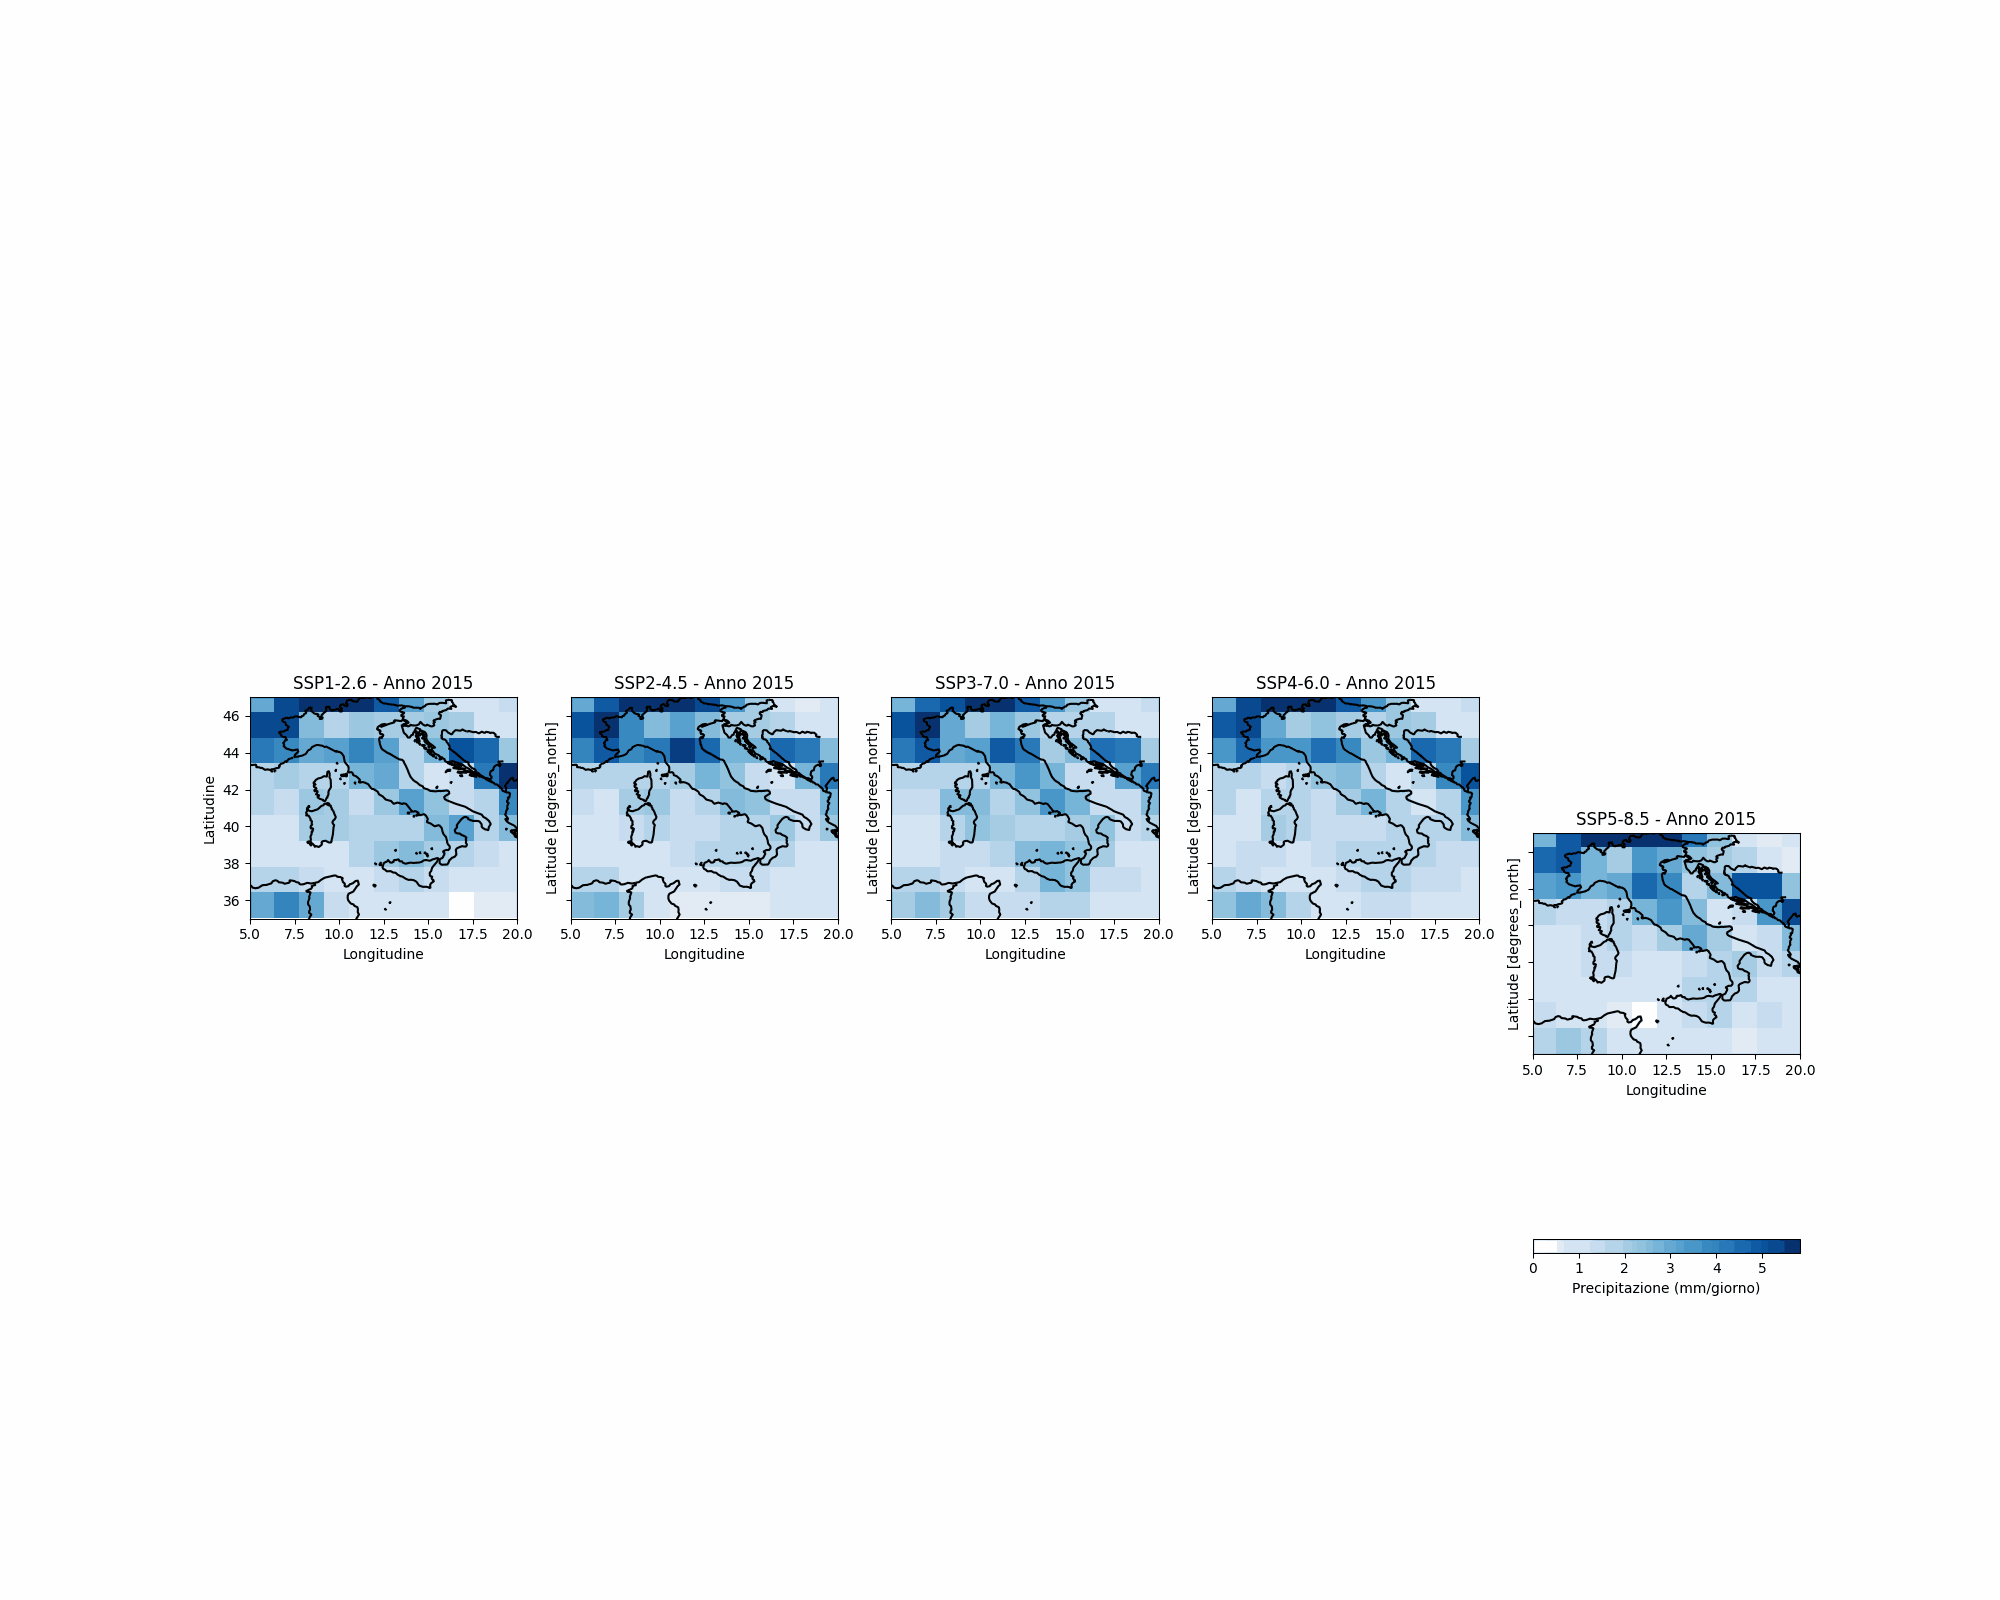

In [47]:
# Display the GIF
from IPython.display import Image

Image(filename=gif_dir / "precipitation.gif")
